In [1]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import json

In [8]:
import requests
from bs4 import BeautifulSoup
import re

def scrap_resto_link(url):
    resto_req = requests.get(url)
    resto_soup = BeautifulSoup(resto_req.text, 'html.parser')
    
    # Extraction de l'adresse
    address = ""
    for div in resto_soup.find_all('div', {'class':'data-sheet__block--text'}):
        text = div.text.strip()
        if not '\n' in text:
            address = text
            break
    
    # Extraction des coordonnées (latitude et longitude)
    latitude, longitude = None, None
    for iframe in resto_soup.find_all('iframe'):
        i_src = iframe.get('src')
        if i_src is None:
            continue
        if "maps" in i_src:
            search = re.search(r'q=([-+]?[0-9]*\.?[0-9]+),([-+]?[0-9]*\.?[0-9]+)', i_src)
            if search:
                latitude = float(search.group(1))
                longitude = float(search.group(2))
    
    # Extraction de la description (s'il y en a)
    description = None
    description_div = resto_soup.find('div', {'class': 'data-sheet__description'})
    if description_div:
        description = description_div.get_text(strip=True)
    
    return address, latitude, longitude, description

# Test de la fonction avec l'URL fournie
url = "https://guide.michelin.com/fr/fr/tokyo-region/tokyo/restaurant/sushiya-hajime"
address, latitude, longitude, description = scrap_resto_link(url)

print("Address:", address)
print("Latitude:", latitude)
print("Longitude:", longitude)
print("Description:", description)


Address: 2F, 4-3 Kagurazaka, Shinjuku-ku, Tokyo, 162-0825, Japon
Latitude: 35.701694
Longitude: 139.740107
Description: The character for ‘sushi’ in Sushiya Hajime refers specifically to fermented sushi, harking back to the beginnings of sushi culture. ‘Hajime’ means ‘beginning’, expressing the chef’s desire to see the sushi world with a newcomer’s eyes, as when he used to be sent to select fish at the market. Fish is prepared according to ancient practices such as salting and simmering. Omakase set meals consist of numerous pieces of sushi formed small, affording rich variety and commitment to quality is uncompromising, which is deeply satisfying. Finely honed skills shine in attentive service.


In [ ]:
def scrap_resto_link(url):
    resto_req = requests.get(url)
    resto_soup = BeautifulSoup(resto_req.text, 'html.parser')
    address = ""
    for div in resto_soup.find_all('div', {'class':'data-sheet__block--text'}):
        text = div.text.strip()
        if not '\n' in text:
            address = text
            break
    latitude, longitude = None, None
    for iframe in resto_soup.find_all('iframe'):
        i_src = iframe.get('src')
        if i_src is None:
            continue
        if "maps" in i_src:
            search = re.search(r'q=([-+]?[0-9]*\.?[0-9]+),([-+]?[0-9]*\.?[0-9]+)', i_src)
            if search:
                latitude = float(search.group(1))
                longitude = float(search.group(2))
    return address, latitude, longitude
scrap_resto_link("https://guide.michelin.com/fr/fr/tokyo-region/tokyo/restaurant/sushiya-hajime")

In [2]:
import pandas as pd
import json
import re
from googletrans import Translator
from unidecode import unidecode
from nltk.corpus import stopwords
from rapidfuzz import fuzz
import nltk
import numpy as np



In [9]:
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

In [6]:


try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
def group_df(df,threshold=80):

    def combined_token_sort_ratio(s1, s2):
        return 0.4 * fuzz.token_sort_ratio(s1, s2) + 0.6 * fuzz.partial_token_sort_ratio(s1, s2)

    # Trouver la meilleure correspondance dans un sous-ensemble du DataFrame
    def find_best_match(query, grouped_df):
        best_match, best_score = None, 0
        for idx in grouped_df.index:
            choice = grouped_df.loc[idx, 'Title_english']
            score = combined_token_sort_ratio(query, choice)
            if score > best_score:
                best_match, best_score = idx, score
        return (best_match, best_score) if best_match is not None else None

    # Groupement des titres similaires
    df['group'] = None
    last_group = 0
    
    for index in df.index:
        sub_df = df[(df['group'].notnull()) & (df['site'] != df.loc[index, 'site'])]
        match = find_best_match(df.loc[index, 'Title_english'], sub_df)

        if match and match[1] >= threshold:
            df.loc[index, 'group'] = df.loc[match[0], 'group']
        else:
            df.loc[index, 'group'] = last_group
            last_group += 1
    return df


def merge_groups(df):
    merged_df = pd.DataFrame()

    for group in df['group'].unique():
        group_df = df[df['group'] == group]
        # Initialiser une ligne vide pour la fusion
        merged_row = {}

        filtered_group_df = group_df[group_df['VO'] == True]
        if not filtered_group_df.empty and filtered_group_df['Title'].notnull().any():
            merged_row['Title'] = filtered_group_df.loc[filtered_group_df['Title'].str.len().idxmin()]['Title']
        else:
            merged_row['Title'] = group_df.loc[group_df['Title'].str.len().idxmin()]['Title']

        # Fusionner la colonne 'site' en concaténant les valeurs, en évitant les doublons
        sites = group_df['site'].dropna().unique()
        merged_row['site'] = ', '.join(sites) if len(sites) > 0 else None

        # Calculer le 'rank' moyen pour le groupe
        merged_row['rank'] = group_df['rank'].mean()

        # Ajouter la 'count' pour le groupe
        merged_row['count'] = len(group_df)
        # Fusionner les colonnes avec la logique décrite
        for column in group_df.columns:

            if column not in ['site','rank', 'count','Title', 'group','VO']:  # Ne pas fusionner ces colonnes
                # On prend la valeur avec le plus grand nombre de caractères ou None
                values = group_df[column].dropna()
                if not values.empty:
                    merged_row[column] = max(values, key=len)  # La valeur avec le plus grand nombre de caractères
                else:
                    merged_row[column] = None
        # Ajouter la ligne fusionnée au DataFrame final
        merged_df = pd.concat([merged_df, pd.DataFrame([merged_row])], ignore_index=True)

    return merged_df

def process_data_pipeline(df,df_michelin, language, threshold=80):

    
    translator = Translator()
    stop_words = set(stopwords.words('french') + stopwords.words('english'))


    # Détection et traduction du texte en anglais
    def detect_and_translate(text,lang = 'en'):
        try:
            detected_lang = translator.detect(text).lang
            if detected_lang == lang:
                return text, False  # Pas besoin de traduction
            translated = translator.translate(text, dest=lang).text
            return translated, True
        except Exception as e:
            return f"Erreur: {e}", False
    
    print('merge of the attractions ...')
    df[['Title_english', 'VO']] = df['Title'].apply(lambda x: pd.Series(detect_and_translate(x)))

    # Nettoyage des textes
    def clean_text(text):
        text = unidecode(text)  # Supprime les accents
        text = re.sub(r'\W+', ' ', text).lower()  # Supprime caractères spéciaux
        unique_words = []  # Liste pour stocker les mots uniques
        for word in text.split():
            if word not in stop_words and word not in unique_words:
                unique_words.append(word)
        return ' '.join(unique_words)
    
    df['Title_english'] = df['Title_english'].apply(clean_text)

    # Fonction pour combiner les scores de similarité
    df = group_df(df)
    df.drop(columns = 'Title_english', inplace=True)

    df_merged = merge_groups(df).sort_values(by=['count', 'rank'], ascending=[False, True], inplace=False)
    df_merged.reset_index(drop=True, inplace=True)
    print('traduction ...')
    df_merged['description'] = df_merged['description'].apply(lambda x: detect_and_translate(x,language)[0] if x else None)
    df_michelin['description'] = df_michelin['description'].apply(lambda x: detect_and_translate(x,language)[0] if x else None)
    return df_merged,df_michelin


# Créer un exemple de DataFrame
with open("data/raw/df_germany_berlin.json", "r", encoding="utf-8") as file:
    data = json.load(file)
df_main = pd.DataFrame(data['attractions'])
df_michelin = pd.DataFrame(data['michelin'])

processed_df,michelin = process_data_pipeline(df_main, df_michelin, language = 'de')



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


merge of the attractions ...
traduction ...


In [11]:
import os
directory = "data/clusters/"
filename = "afnf"
print(os.path.join(directory, filename))

data/clusters/afnf


In [ ]:
michelin

In [5]:
with open("data/raw/df_tokyo_japan.json", "r", encoding="utf-8") as file:
    data = json.load(file)
df_main = pd.DataFrame(data['attractions'])
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   site             126 non-null    object
 1   Title            126 non-null    object
 2   Description      42 non-null     object
 3   rank             126 non-null    int64 
 4   Opening times    7 non-null      object
 5   Website          6 non-null      object
 6   Admission Fees   7 non-null      object
 7   Disabled Access  7 non-null      object
 8   Good for age     44 non-null     object
 9   Duration         44 non-null     object
 10  When             40 non-null     object
 11  Freq             40 non-null     object
 12  Adult price      20 non-null     object
dtypes: int64(1), object(12)
memory usage: 12.9+ KB


In [2]:
with open("data/processed/df_germany_berlin_fr.json", "r", encoding="utf-8") as file:
    data = json.load(file)
df_main = pd.DataFrame(data['attractions'])
df_michelin = pd.DataFrame(data['michelin'])

In [3]:
from haversine import haversine, Unit
from geopy.geocoders.nominatim import Nominatim


In [4]:
def create_cluster(df,df2,country,city):

    geolocator = Nominatim(user_agent="test2")
    
    def geocode_addresses(address):
        try:
            # Appeler l'API pour obtenir les coordonnées complètes (adresse + ville)
            location = geolocator.geocode(f"{address}, {city}, {country}")
            if location:
                return pd.Series([location.latitude, location.longitude])  # Retourne les valeurs sous forme de série
            else:
                print(f"Location not found: {address}")
                return pd.Series([None, None])
        except Exception as e:
            print(f"Error with address '{address}': {e}")
            return pd.Series([None, None])

    # Appliquer la fonction sur chaque ligne de la colonne 'title'
    df[['latitude', 'longitude']] = df['Title'].apply(lambda x: geocode_addresses(x))
    return df

df = create_cluster(df_main, None,"germany","berlin")
    

Error with address 'Jüdisches Museum': HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=J%C3%BCdisches+Museum%2C+berlin%2C+germany&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
Location not found: Hackesche Höfe and Haus Schwarzenberg
Location not found: World-class art in Berlin
Location not found: Stasi Prison
Location not found: Gallery of Old Masters
Location not found: Sachsenhausen Concentration Camp
Error with address 'Hamburger Bahnhof – Museum für Gegenwart': HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Hamburger+Bahnhof+%E2%80%93+Museum+f%C3%BCr+Gegenwart%2C+berlin%2C+germany&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
Location not found: Berlin 

In [6]:
df.drop(df[df['latitude'].isna() | df['longitude'].isna()].index, inplace=True)
df.reset_index(drop=True, inplace=True)


In [3]:
def create_clusters(df_attraction, df_michelin, radius_km):
    clusters = {}  

    # Pour chaque restaurant Michelin, on va vérifier sa proximité avec chaque attraction
    for i, restaurant in df_michelin.iterrows():
        lat_restaurant = restaurant['latitude']
        lon_restaurant = restaurant['longitude']
        
        # Liste des attractions associées à ce restaurant
        attractions_nearby = []

        for j, attraction in df_attraction.iterrows():
            lat_attraction = attraction['latitude']
            lon_attraction = attraction['longitude']
            
            # Calcul de la distance entre le restaurant et l'attraction
            distance = haversine((lat_restaurant, lon_restaurant), (lat_attraction, lon_attraction))
            
            # Si la distance est inférieure au rayon défini, on l'ajoute à la liste des attractions proches
            if distance <= radius_km:
                attractions_nearby.append(attraction['Title'])
        
        # Si des attractions ont été trouvées à proximité du restaurant, on les ajoute au dictionnaire
        if attractions_nearby:
            clusters[restaurant['name']] = attractions_nearby
    
    return clusters


In [14]:
def create_clusters(df_attraction, df_michelin, radius_km):
    clusters = []  # Liste pour stocker les clusters
    
    # Pour chaque restaurant Michelin, on va vérifier sa proximité avec chaque attraction
    for i, restaurant in df_michelin.iterrows():
        lat_restaurant = restaurant['latitude']
        lon_restaurant = restaurant['longitude']
        
        # Liste des attractions associées à ce restaurant
        attractions_nearby = []
        
        for j, attraction in df_attraction.iterrows():
            lat_attraction = attraction['latitude']
            lon_attraction = attraction['longitude']
            
            # Calcul de la distance entre le restaurant et l'attraction
            distance = haversine((lat_restaurant, lon_restaurant), (lat_attraction, lon_attraction))
            
            # Si la distance est inférieure au rayon défini, on l'ajoute à la liste des attractions proches
            if distance <= radius_km:
                attractions_nearby.append(attraction['Title'])
        
        # Si des attractions ont été trouvées à proximité du restaurant, on les ajoute à la liste des clusters
        if attractions_nearby:
            clusters.append({
                'restaurant_name': restaurant['name'],
                'attractions': attractions_nearby,
                'num_attractions': len(attractions_nearby),
                'is_bib_gourmand': restaurant.get('bib-gourmand', False), # Assurez-vous que cette colonne existe
                'is_gastonomie_durable': restaurant.get('gastonomie-durable', False)
            })
    
    # Trier les clusters en fonction des critères
    # 1. Par nombre d'attractions (décroissant)
    # 2. Si nombre d'attractions égales, par 'is_bib_gourmand' (True > False)
    # 3. Si tout est égal, on garde le premier trouvé
    clusters.sort(key=lambda x: (-x['num_attractions'], not x['gastonomie-durable'],not x['is_bib_gourmand']))
    
    return clusters


In [ ]:
def create_clusters(df_attraction, df_michelin, radius_km, n_activites):
    clusters = []  # Liste pour stocker les clusters sous la nouvelle forme demandée
    
    # Pour chaque restaurant Michelin, vérifier sa proximité avec chaque attraction
    for _, restaurant in df_michelin.iterrows():
        lat_restaurant = restaurant['latitude']
        lon_restaurant = restaurant['longitude']

        # Liste des attractions associées à ce restaurant
        attractions_nearby = []
        
        for _, attraction in df_attraction.iterrows():
            lat_attraction = attraction['latitude']
            lon_attraction = attraction['longitude']

            # Calcul de la distance entre le restaurant et l'attraction
            distance = haversine((lat_restaurant, lon_restaurant), (lat_attraction, lon_attraction))
            
            # Si la distance est inférieure au rayon défini, on l'ajoute
            if distance <= radius_km:
                attractions_nearby.append(attraction.to_dict())
        
        # Ajouter le cluster si des attractions ont été trouvées
        if attractions_nearby:
            cluster = [restaurant.to_dict()] + attractions_nearby
            clusters.append(cluster)
    
    # Filtrer les clusters qui ont au moins n_activites
    clusters = [cluster for cluster in clusters if len(cluster) >= n_activites + 1]
    
    # Si aucun cluster ne respecte la contrainte, renvoyer le plus long si sa taille est > 3
    if not clusters:
        longest_cluster = max(clusters, key=len, default=None)
        return longest_cluster if longest_cluster and len(longest_cluster) > 3 else None

    return clusters


In [13]:
for j, attraction in df_michelin[:10].iterrows():
    print(attraction.get('bib-gourmand'),"")

False 
False 
False 
False 
False 
True 
False 
True 
False 
False 


In [8]:
df_michelin_filter = df_michelin[df_michelin['cost']=='Mid-Range']
clusters = create_clusters(df,df_michelin_filter, 1)

In [9]:
clusters

[{'restaurant_name': 'Bocca di Bacco',
  'attractions': ['Museumsinsel',
   'Brandenburger Tor',
   'Reichstag',
   'Checkpoint Charlie',
   'Memorial to the Murdered Jews of Europe',
   'Sammlung Boros',
   'Neues Museum',
   'Deutsches Historisches Museum',
   'Pergamon Museum',
   'Old Museum',
   'Berlin Cathedral',
   'Humboldt Forum',
   'Old National Gallery',
   'Holocaust Mahnmal',
   'Unter den Linden',
   'German Spy Museum'],
  'num_attractions': 16,
  'is_bib_gourmand': False,
  'is_gastonomie_durable': False},
 {'restaurant_name': 'Restaurant 1687',
  'attractions': ['Museumsinsel',
   'Brandenburger Tor',
   'Reichstag',
   'Memorial to the Murdered Jews of Europe',
   'Sammlung Boros',
   'Neues Museum',
   'Deutsches Historisches Museum',
   'Pergamon Museum',
   'Old Museum',
   'Old National Gallery',
   'Holocaust Mahnmal',
   'Unter den Linden'],
  'num_attractions': 12,
  'is_bib_gourmand': False,
  'is_gastonomie_durable': False},
 {'restaurant_name': 'Berta',
  

In [ ]:
from sklearn.cluster import DBSCAN



In [ ]:
# Clustering des points avec DBSCAN

coords =list(geocode.values())

kms_per_radian = 6371.0088

epsilon = 5 / kms_per_radian

db = DBSCAN(

    eps=epsilon, min_samples=1, algorithm="ball_tree", metric="haversine"

).fit(np.radians(coords))

labels = db.labels_



# Ajout des labels au dataframe

df["cluster"] = labels

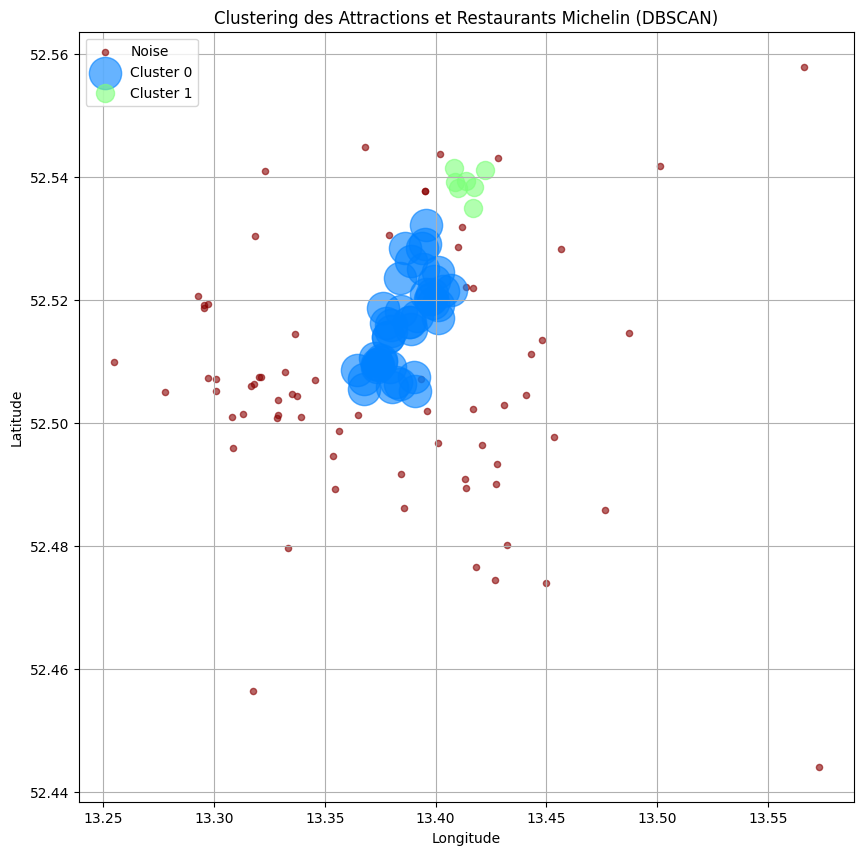

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Supposons que df_attraction et df_michelin sont déjà définis et contiennent des colonnes 'latitude' et 'longitude'

# Fusionner les deux DataFrames : df_attraction et df_michelin
df_combined = pd.concat([df[['latitude', 'longitude']], df_michelin[['latitude', 'longitude','name']]])
df_combined.reset_index(inplace=True)
# Convertir les coordonnées en radians pour DBSCAN avec la métrique haversine
coords = df_combined[['latitude', 'longitude']].values
kms_per_radian = 6371.0088  # Rayon de la Terre en km
epsilon = 0.5 / kms_per_radian  # Rayon de 5 km en radians

# Appliquer DBSCAN avec la métrique haversine
db = DBSCAN(eps=epsilon, min_samples=5, algorithm="ball_tree", metric="haversine")
labels = db.fit_predict(np.radians(coords))

# Ajouter les labels de cluster au DataFrame combiné
df_combined['cluster'] = labels

# Visualisation des clusters
plt.figure(figsize=(10, 10))

# Trouver les couleurs uniques pour chaque cluster
unique_labels = np.unique(labels)

# Boucle pour chaque cluster
for i,label in enumerate(unique_labels):
    cluster_points = df_combined[df_combined['cluster'] == label]
    
    if label == -1:
        # Les points de bruit (non affectés à un cluster) sont représentés en noir
        color = plt.cm.jet(0.99)
        size = 20
    else:
        # On assigne une couleur différente pour chaque cluster
        color = plt.cm.jet((label + 1) / (len(unique_labels) + 1))  # Une couleur unique pour chaque cluster
        size = 100 + len(cluster_points) * 10  # Taille du cercle basée sur le nombre de points dans le cluster
    if type(df_combined.loc[i,'name'])!=float:
        color = plt.cm.jet(0.9)
        size = 150
    # Tracer les points de chaque cluster
    plt.scatter(cluster_points['longitude'], cluster_points['latitude'], 
                label=f"Cluster {label}" if label != -1 else "Noise", 
                color=color, s=size, alpha=0.6)

# Ajouter un titre et des labels
plt.title("Clustering des Attractions et Restaurants Michelin (DBSCAN)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Afficher la légende
plt.legend()

# Afficher la carte
plt.grid(True)
plt.show()


In [51]:
type(df_combined.loc[75,'name'])!=float

True

In [27]:
df_combined.reset_index(inplace=True)

In [23]:
df_combined

,latitude,longitude,name,cluster
0,52.520033,13.397815,NaN,0
1,52.520642,13.292710,NaN,-1
2,52.504454,13.440839,NaN,-1
3,52.516270,13.377703,NaN,0
4,52.518654,13.376102,NaN,0
...,...,...,...,...
55,52.505803,13.380316,Berta,0
56,52.513393,13.448059,Jäger & Lustig,-1
57,52.491586,13.384604,Tupac,-1
58,52.539072,13.408627,MaMi's,1
